In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import *
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV 
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

/Users/gongtingpeng/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
train = pd.read_feather('tmp/train-lat-long')
test = pd.read_feather('tmp/test-lat-long')

In [6]:
X = train.drop(['any_spot', 'Real.Spots'], axis=1)
Y = train['any_spot']

In [7]:
sum(Y == 0), sum(Y == 1)

(699, 401)

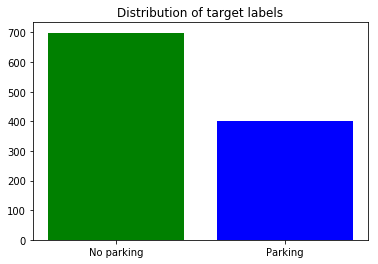

In [8]:
plt.bar(x = ['No parking', 'Parking'], height = [699, 401], color = ['green', 'blue'])
plt.title('Distribution of target labels')
plt.savefig('paiking.png')
plt.show()

In [6]:
#Handles class imbalance through sampling
classDistribution = train['any_spot'].value_counts()
print('Class imbalance:')
print(classDistribution)
train = train.sample(frac=1).reset_index(drop=True)
zero = train[train['any_spot']==0].tail(classDistribution.min())
one = train[train['any_spot']==1]
train_data = zero.append(one)
del zero, one
train_data = train_data.sample(frac=1).reset_index(drop=True)
#del train
print('Class imbalance evened out:')
print(train_data['any_spot'].value_counts())

Class imbalance:
0    699
1    401
Name: any_spot, dtype: int64
Class imbalance evened out:
1    401
0    401
Name: any_spot, dtype: int64


In [10]:
X = train.drop(['any_spot', 'Real.Spots'], axis=1)
Y = train['any_spot']

In [11]:
sum(Y == 0), sum(Y == 1)

(699, 401)

In [12]:
X['lat_from'], X['lon_from'] = X.lat_long_from.str.split(',').str

_, X['lat_from'] = X.lat_from.str.split(':').str

X['lat_from'] =  X['lat_from'].astype(str).astype(float)

_, X['lon_from'] = X.lon_from.str.split(':').str
X['lon_from'] =  X['lon_from'].astype(str).astype(float)

X = X.drop(['lat_long_from'], axis = 1)

X['lat_to'], X['lon_to'] = X.lat_long_to.str.split(',').str

_, X['lat_to'] = X.lat_to.str.split(':').str
X['lat_to'] =  X['lat_to'].astype(str).astype(float)

_, X['lon_to'] = X.lon_to.str.split(':').str
X['lon_to'] =  X['lon_to'].astype(str).astype(float)

X = X.drop(['lat_long_to'], axis = 1)
X = X.drop(['combined'], axis = 1)

test['lat_from'], test['lon_from'] = test.lat_long_from.str.split(',').str

_, test['lat_from'] = test.lat_from.str.split(':').str

test['lat_from'] =  test['lat_from'].astype(str).astype(float)

_, test['lon_from'] = test.lon_from.str.split(':').str
test['lon_from'] =  test['lon_from'].astype(str).astype(float)

test = test.drop(['lat_long_from'], axis = 1)

test['lat_to'], test['lon_to'] = test.lat_long_to.str.split(',').str

_, test['lat_to'] = test.lat_to.str.split(':').str
test['lat_to'] =  test['lat_to'].astype(str).astype(float)

_, test['lon_to'] = test.lon_to.str.split(':').str
test['lon_to'] =  test['lon_to'].astype(str).astype(float)

test = test.drop(['lat_long_to'], axis = 1)
test = test.drop(['combined'], axis = 1)

In [14]:
X.head()

,Street,From,To,Street.Length,from_to,STREET_NAME_x,occ_per_1,vac_per_1,occ_per_2,vac_per_2,...,mean_hr_any,mean_hr_real,mean_dow_any,mean_dow_real,mean_month_any,mean_month_real,lat_from,lon_from,lat_to,lon_to
0,MISSION STREET,25th Street,26th Street,179.132970,25th Street26th Street,MISSION STREET,0.551448,0.414499,0.673388,0.321598,...,0.428571,1.55102,0.329787,1.276596,0.502924,3.912281,37.750648,-122.418316,37.749044,-122.418166
1,POLK STREET,Ellis Street,Olive Street,52.740210,Ellis StreetOlive Street,POLK STREET,0.435176,0.473185,0.617462,0.349815,...,0.236559,1.00000,0.415493,2.102113,0.502924,3.912281,37.784040,-122.419381,37.784507,-122.419478
2,VAN NESS AVENUE,Geary Boulevard,Myrtle Street,52.517840,Geary BoulevardMyrtle Street,VAN NESS AVENUE,0.353977,0.645017,0.447894,0.550980,...,0.236559,1.00000,0.415493,2.102113,0.502924,3.912281,37.785660,-122.421476,37.785241,-122.421234
3,VAN NESS AVENUE,Bush Street,Fern Street,52.405315,Bush StreetFern Street,VAN NESS AVENUE,0.353977,0.645017,0.447894,0.550980,...,0.236559,1.00000,0.415493,2.102113,0.502924,3.912281,37.788499,-122.421892,37.788044,-122.421802
4,VAN NESS AVENUE,Daniel Burnham Court,Post Street,52.191193,Daniel Burnham CourtPost Street,VAN NESS AVENUE,0.353977,0.645017,0.447894,0.550980,...,0.236559,1.00000,0.415493,2.102113,0.502924,3.912281,37.787084,-122.421757,37.786642,-122.421517


In [15]:
test.head()

,Street,From,To,Street.Length,from_to,STREET_NAME_x,occ_per_1,vac_per_1,occ_per_2,vac_per_2,...,mean_hr_any,mean_hr_real,mean_dow_any,mean_dow_real,mean_month_any,mean_month_real,lat_from,lon_from,lat_to,lon_to
0,STOCKTON STREET,Stockton Tunnel,Stockton Street,35.786472,Stockton TunnelStockton Street,STOCKTON STREET,0.759830,0.239126,0.867197,0.131638,...,0.428571,1.551020,0.292576,0.812227,0.321117,1.235602,37.792771,-122.407649,37.794064,-122.407922
1,VAN NESS AVENUE,Hayes Street,Van Ness Avenue,63.787968,Hayes StreetVan Ness Avenue,VAN NESS AVENUE,0.353977,0.645017,0.447894,0.550980,...,0.285714,0.659341,0.292576,0.812227,0.321117,1.235602,37.777313,-122.419633,37.791702,-122.422690
2,VAN NESS AVENUE,McAllister Street,Van Ness Avenue,56.007236,McAllister StreetVan Ness Avenue,VAN NESS AVENUE,0.353977,0.645017,0.447894,0.550980,...,0.290323,1.118280,0.292576,0.812227,0.321117,1.235602,37.780095,-122.420190,37.781046,-122.420392
3,MISSION STREET,11th Street,Mission Street,139.651900,11th StreetMission Street,MISSION STREET,0.551448,0.414499,0.673388,0.321598,...,0.236559,1.000000,0.292576,0.812227,0.321117,1.235602,37.774332,-122.417137,37.773067,-122.418720
4,HYDE STREET,Golden Gate Avenue,McAllister Street,105.144110,Golden Gate AvenueMcAllister Street,HYDE STREET,0.506700,0.369059,0.688952,0.186181,...,0.290323,1.118280,0.292576,0.812227,0.321117,1.235602,37.781668,-122.415524,37.780706,-122.415334


In [16]:
X = X.drop(['STREET_NAME_x', 'STREET_NAME_y'], axis = 1)
test = test.drop(['STREET_NAME_x', 'STREET_NAME_y'], axis = 1)

category = ["Street", "From", "To","from_to"]

le = LabelEncoder()
for cat in category:
    le.fit(X[cat])
    X[cat] = le.transform(X[cat])
    test[cat] = le.transform(test[cat])

X = X.fillna(0)
test = test.fillna(0)

In [20]:
m = RandomForestClassifier(n_jobs = -1, n_estimators=50)
m.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'col' : df.columns, 'feat_imp' : m.feature_importances_}
                       ).sort_values('feat_imp', ascending = False)
fi = rf_feat_importance(m, X)
fi

,col,feat_imp
22,mean_from_to_any,0.120903
23,mean_from_to_real,0.083954
20,min,0.083815
26,mean_hr_any,0.059821
27,mean_hr_real,0.055351
19,hr,0.047578
18,Dayofyear,0.044058
16,Day,0.042848
3,Street.Length,0.038593
35,lon_to,0.030676


In [12]:
names = fi.col.values[:15]
values = fi.feat_imp.values[:15]


In [13]:
names, values

(array(['mean_from_to_any', 'mean_from_to_real', 'min', 'mean_hr_any',
        'mean_hr_real', 'hr', 'Street.Length', 'Dayofyear', 'Day',
        'lon_from', 'lat_from', 'lon_to', 'lat_to', 'from_to', 'Week'],
       dtype=object),
 array([0.11910255, 0.09932451, 0.07615314, 0.06102269, 0.05031707,
        0.05027612, 0.04693377, 0.04115668, 0.04043578, 0.03746106,
        0.03456206, 0.03175547, 0.0311116 , 0.02919698, 0.02802226]))

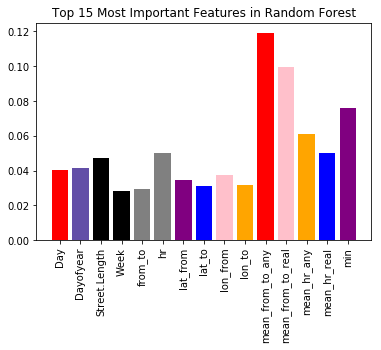

In [14]:
plt.bar(names, height = values, color = ['red', 'pink', 'purple', 'orange', 'blue', 'grey', 'k', '#624ea7'])
plt.xticks(rotation=90)
plt.title('Top 15 Most Important Features in Random Forest')
plt.savefig('Feautes.png')
plt.show()

In [22]:
to_keep = fi[fi.feat_imp > 0.005].col
train = X[to_keep].copy()
#train_keep = train_keep.drop('Dayofyear', axis = 1)
test = test[to_keep].copy()
#test_keep = test_keep.drop('Dayofyear', axis = 1)

In [23]:
params = {
    'min_samples_split' : [5, 8, 10, 12],
    'min_samples_leaf' : [3, 5, 7, 9],
    'max_features' : ['sqrt', 'log2', 0.8, 0.9]
}

f_scorer = make_scorer(fbeta_score, beta=0.5)


In [24]:
fgrid = GridSearchCV(estimator = m, param_grid = params, cv = 5, n_jobs= -1, 
                     scoring = 'roc_auc', iid = False, verbose = 50)
fgrid.fit(X, Y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=5 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=5 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=5 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=5 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=5 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=8 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=8 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=8 ......
[CV]  max_features=sqrt, min_samples_leaf=3, min_samples_split=5, score=0.4047321428571428, total=   0.3s
[CV]  max_features=sqrt, min_samples_leaf=3, min_samples_split=5, score=0.6469135802469136, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=8 ......
[CV] max_features=sqrt, min_samples_leaf=3, min_samples_split=8 ......
[CV]  max_featur

[CV]  max_features=sqrt, min_samples_leaf=5, min_samples_split=10, score=0.6367857142857142, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=7, min_samples_split=5 ......
[CV]  max_features=sqrt, min_samples_leaf=5, min_samples_split=10, score=0.8328237410071943, total=   0.3s
[CV]  max_features=sqrt, min_samples_leaf=5, min_samples_split=10, score=0.48852678571428576, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=7, min_samples_split=5 ......
[CV] max_features=sqrt, min_samples_leaf=7, min_samples_split=5 ......
[CV]  max_features=sqrt, min_samples_leaf=5, min_samples_split=12, score=0.6085537918871251, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=7, min_samples_split=5 ......
[CV]  max_features=sqrt, min_samples_leaf=5, min_samples_split=12, score=0.3950892857142857, total=   0.3s
[CV]  max_features=sqrt, min_samples_leaf=5, min_samples_split=12, score=0.5305803571428571, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=7, min_samples_split=5 ......
[C

[CV] max_features=sqrt, min_samples_leaf=9, min_samples_split=12 .....
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.8s
[CV]  max_features=sqrt, min_samples_leaf=9, min_samples_split=8, score=0.6714285714285714, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=9, min_samples_split=12 .....
[CV]  max_features=sqrt, min_samples_leaf=9, min_samples_split=8, score=0.8542266187050359, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=9, min_samples_split=12 .....
[CV]  max_features=sqrt, min_samples_leaf=9, min_samples_split=10, score=0.5905357142857143, total=   0.3s
[CV] max_features=sqrt, min_samples_leaf=9, min_samples_split=12 .....
[CV]  max_features=sqrt, min_samples_leaf=9, min_samples_split=10, score=0.595679012345

[CV]  max_features=log2, min_samples_leaf=5, min_samples_split=5, score=0.6323214285714286, total=   0.3s
[CV]  max_features=log2, min_samples_leaf=5, min_samples_split=5, score=0.5348660714285715, total=   0.3s
[CV] max_features=log2, min_samples_leaf=5, min_samples_split=10 .....
[CV]  max_features=log2, min_samples_leaf=5, min_samples_split=5, score=0.8374999999999999, total=   0.3s
[CV] max_features=log2, min_samples_leaf=5, min_samples_split=10 .....
[CV] max_features=log2, min_samples_leaf=5, min_samples_split=10 .....
[CV]  max_features=log2, min_samples_leaf=5, min_samples_split=8, score=0.6208112874779541, total=   0.3s
[CV]  max_features=log2, min_samples_leaf=5, min_samples_split=8, score=0.5101785714285714, total=   0.3s
[CV] max_features=log2, min_samples_leaf=5, min_samples_split=10 .....
[CV] max_features=log2, min_samples_leaf=5, min_samples_split=10 .....
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:

[CV]  max_features=log2, min_samples_leaf=7, min_samples_split=12, score=0.6844642857142857, total=   0.3s
[CV] max_features=log2, min_samples_leaf=9, min_samples_split=8 ......
[CV] max_features=log2, min_samples_leaf=9, min_samples_split=8 ......
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:    7.4s
[CV]  max_features=log2, min_samples_leaf=7, min_samples_split=12, score=0.8236510791366907, total=   0.3s
[CV] max_features=log2, min_samples_leaf=9, min_samples_split=8 ......
[CV]  max_features=log2, min_samples_leaf=9, min_samples_split=5, score=0.6201940035273368, total=   0.3s
[CV] max_features=log2, min_samples_leaf=9, min_samples_split=8 ......
[CV]  max_features=log2, min_samples_leaf=9, min_samples_split=5, score=0.542232142857

[CV] max_features=0.8, min_samples_leaf=3, min_samples_split=12 ......
[CV]  max_features=0.8, min_samples_leaf=3, min_samples_split=10, score=0.6049107142857143, total=   0.5s
[CV] max_features=0.8, min_samples_leaf=5, min_samples_split=5 .......
[CV]  max_features=0.8, min_samples_leaf=3, min_samples_split=10, score=0.6535714285714286, total=   0.6s
[CV] max_features=0.8, min_samples_leaf=5, min_samples_split=5 .......
[Parallel(n_jobs=-1)]: Done 171 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    9.9s
[CV]  max_features=0.8, min_samples_leaf=3, min_samples_split=10, score=0.8204136690647481, total=   0.6s
[CV]  max_features=0.8, min_samples_leaf=3, min_samples_split=12, score=0.43562610229276894, total=   0.5s
[CV] max_features=0.8, min_samples_leaf=5, min_samples_split=5 .......
[CV] max_features=0.8, min_samples_leaf=5, 

[CV]  max_features=0.8, min_samples_leaf=7, min_samples_split=8, score=0.5485714285714286, total=   0.4s
[CV] max_features=0.8, min_samples_leaf=7, min_samples_split=10 ......
[CV]  max_features=0.8, min_samples_leaf=7, min_samples_split=8, score=0.596205357142857, total=   0.4s
[CV]  max_features=0.8, min_samples_leaf=7, min_samples_split=8, score=0.6797767857142857, total=   0.4s
[CV]  max_features=0.8, min_samples_leaf=7, min_samples_split=8, score=0.8436151079136691, total=   0.4s
[CV] max_features=0.8, min_samples_leaf=7, min_samples_split=12 ......
[CV] max_features=0.8, min_samples_leaf=7, min_samples_split=12 ......
[CV] max_features=0.8, min_samples_leaf=7, min_samples_split=12 ......
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   12.3s
[CV]  max_features=0.8, min_samples_leaf=7, min_s

[CV]  max_features=0.9, min_samples_leaf=3, min_samples_split=5, score=0.44969135802469135, total=   0.4s
[CV] max_features=0.9, min_samples_leaf=3, min_samples_split=8 .......
[CV]  max_features=0.9, min_samples_leaf=3, min_samples_split=5, score=0.5698214285714285, total=   0.5s
[CV] max_features=0.9, min_samples_leaf=3, min_samples_split=10 ......
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 243 tasks      | elapsed:   14.7s
[CV]  max_features=0.9, min_samples_leaf=3, min_samples_split=5, score=0.6567857142857142, total=   0.5s
[CV]  max_features=0.9, min_samples_leaf=3, min_samples_split=5, score=0.8348021582733813, total=   0.5s
[CV] max_features=0.9, min_samples_leaf=3, min_samples_split=10 ......
[CV] max_features=0.9, min_samples_leaf=3, min_samples_split=10 ......
[CV]  max_features=0.9, min_samples_leaf=3, min_samples_split=8, score=0.5622574955908288, total=   0.4s
[CV] max_features=0.9, min_samples_leaf=3, min_samples_split=10 ..

[CV]  max_features=0.9, min_samples_leaf=5, min_samples_split=12, score=0.4695535714285715, total=   0.6s
[CV]  max_features=0.9, min_samples_leaf=5, min_samples_split=12, score=0.6089285714285714, total=   0.5s
[CV] max_features=0.9, min_samples_leaf=7, min_samples_split=5 .......
[CV] max_features=0.9, min_samples_leaf=7, min_samples_split=8 .......
[CV]  max_features=0.9, min_samples_leaf=5, min_samples_split=12, score=0.6741964285714286, total=   0.5s
[CV] max_features=0.9, min_samples_leaf=7, min_samples_split=8 .......
[CV]  max_features=0.9, min_samples_leaf=7, min_samples_split=5, score=0.5425925925925926, total=   0.4s
[CV] max_features=0.9, min_samples_leaf=7, min_samples_split=8 .......
[CV]  max_features=0.9, min_samples_leaf=5, min_samples_split=12, score=0.8437949640287771, total=   0.5s
[CV] max_features=0.9, min_samples_leaf=7, min_samples_split=8 .......
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 

[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=10, score=0.8576438848920863, total=   0.4s
[Parallel(n_jobs=-1)]: Done 312 out of 320 | elapsed:   20.0s remaining:    0.5s
[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=10, score=0.6148214285714285, total=   0.4s
[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=12, score=0.5298941798941799, total=   0.3s
[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=12, score=0.5770535714285714, total=   0.3s
[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=12, score=0.6942857142857143, total=   0.4s
[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=12, score=0.6414285714285713, total=   0.4s
[CV]  max_features=0.9, min_samples_leaf=9, min_samples_split=12, score=0.8430755395683454, total=   0.5s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   20.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'min_samples_split': [5, 8, 10, 12], 'min_samples_leaf': [3, 5, 7, 9], 'max_features': ['sqrt', 'log2', 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=50)

In [25]:
print(fgrid.best_params_)

{'max_features': 0.8, 'min_samples_leaf': 9, 'min_samples_split': 5}


In [26]:
fgrid.best_score_, fgrid.best_estimator_  #without top features

(0.67396121118977836,
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.8, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=9, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [28]:
X_train, X_val, y_train, y_val = train_test_split(train, Y, test_size = .2, random_state=5)

In [31]:
m = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.8, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=9, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
fbeta_score(beta=0.5, y_pred=m.predict(X_val), y_true=y_val)


0.63049853372434017

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, m.predict(X_val))
cm

array([[114,  21],
       [ 42,  43]])

In [34]:
print('Precision: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][1]+cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')

Precision: 67.19%
Recall: 50.59%


In [35]:
m.fit(train, Y)
sum(m.predict(test))

136

In [40]:
prediction = {"id":range(1,727), "any_spot":m.predict(test)}

sub_rf_v5 = pd.DataFrame(prediction)

sub_rf_v5 = sub_rf_v5.astype("int")

sub_rf_v5.to_csv("sub_rf_reg.csv", index =False)